In [239]:
from food.tools import *
from food.paths import *
from food.psql import *
import numpy as np
import torch
from torch.nn import CosineSimilarity
import requests
from food.qdrant import *
cos = CosineSimilarity(dim=1, eps=1e-08)
import pandas as pd

In [240]:
#export
def search_image(url=None,head = 1):
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [241]:
collection_name = 'food'
table = 'foods'
foods = read_sql(table)
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')

In [242]:
url = 'http://glovo.away.guru/photos_resized/NZTCKFL_0076494_1516096262.png'
image_clip,df = search_image(url,head=100)

In [243]:
selected = df.copy()

In [244]:
selected = selected.reset_index(drop=True)
clip = series2tensor(selected['clip'])
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

In [249]:
selected = selected.reset_index(drop=True)
for i in reversed(selected.index):
    clip = series2tensor(selected['clip'])
    T = torch.cat([clip[0:i], clip[i+1:]])
    testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
    if testscore > initscore: 
        r = selected.loc[i,'description']
        selected = selected.drop(i)
        initscore = testscore
        # print(f"removed {r}")
    else:
        T = torch.cat([clip, clip[i].reshape(1,768)])
        testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
        if testscore > initscore: 
            selected = selected.append(selected.loc[i])
            # print(f"added {selected.loc[i,'description']}")
            initscore = testscore

    



print(initscore)
count = selected.groupby('description')['clip'].count().sort_index()
r = selected.drop_duplicates('description').set_index("description").sort_index()
r['count'] = count
r.sort_values('count',ascending = False)

tensor([0.2922], dtype=torch.float64)


,id,category,energy,protein,carb,fat,clip,score,count
description,,,,,,,,,
"Fritter, apple",1101153,"Doughnuts, sweet rolls, pastries",381.0,6.46,34.75,24.46,"[0.057608202, 0.031312082, 0.02672885, -0.0110...",0.258467,6
"Apple, raw",1102644,Apples,52.0,0.26,13.81,0.17,"[0.03289434, 0.009451146, 0.04302109, -0.00526...",0.274602,5
"Cobbler, apple",1101144,Cakes and pies,194.0,2.31,36.38,4.95,"[0.03982123, -0.021529237, 0.030978544, -0.001...",0.239396,4
"Turnover or dumpling, apple",1101181,Cakes and pies,348.0,3.64,43.55,18.08,"[0.047357026, 0.0405507, -0.015996952, -0.0136...",0.246986,4
"Apples, baby food, toddler",1102782,Baby food: fruit,50.0,0.19,11.56,0.36,"[0.0003478544, -0.022820584, 0.033641424, 0.00...",0.245114,2
"Crepe, plain",1101513,"Pancakes, waffles, French toast",223.0,8.78,21.73,10.93,"[0.07472039, 0.041357704, -0.0068391925, -0.01...",0.219865,2
"Kohlrabi, raw",1103356,Other vegetables and combinations,27.0,1.70,6.20,0.10,"[0.046535134, -0.025247127, -0.0028286164, -0....",0.205997,2
Nutrition bar (Balance Original Bar),1101259,Nutrition bars,415.0,28.00,48.73,12.00,"[-0.01209534, 0.0036753116, 0.058078367, -0.00...",0.202616,2
"Whole wheat cereal with apples, baby food, dry, instant",1101839,Baby food: cereals,402.0,6.60,83.20,4.80,"[0.017155621, 0.015462028, 0.0072350083, 0.017...",0.214636,2


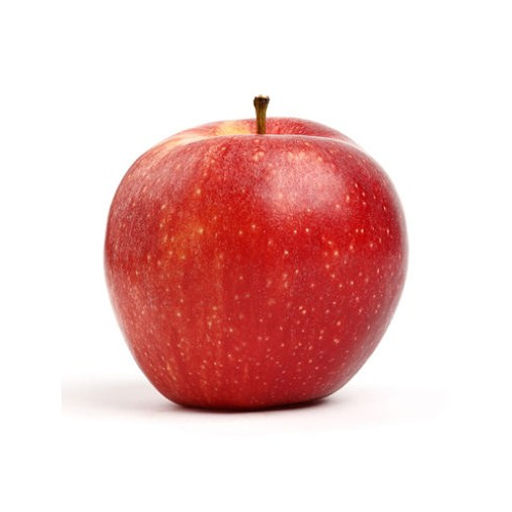

In [250]:
read_image_from_url(url)

use prompts sand alterations to dish names

In [550]:
url = 'https://image.shutterstock.com/image-photo/smorrebrod-traditional-danish-sandwiches-long-600w-1907860309.jpg'
image_clip,df = search_image(url,head=100)

In [551]:
selected = df.copy()

In [552]:
selected['description'].str.split(',').apply(lambda l:' '.join(list(reversed(l))))

0      made with margarine  baked or broiled  coated...
1          made with margarine  baked or broiled Salmon
2      made with margarine  baked or broiled  NS as ...
3             made with margarine  fried  coated Salmon
4                            with spread Hors d'oeuvres
                            ...                        
95               with filling  sandwich Graham crackers
96     made with cooking spray  baked or broiled  NS...
97                                      pickled Herring
98                    reduced fat  woven wheat Crackers
99                                         smoked Trout
Name: description, Length: 100, dtype: object

In [553]:
selected['altered_description'] = 'I am going to eat some ' +selected['description'].str.split(',').apply(lambda l:' '.join(list(reversed(l)))) + ' which is ' + selected['category'] #selected['category']#+' '+selected['description'].str.replace(',','') I am going to eat some 

In [554]:
selected

,id,description,category,energy,protein,carb,fat,clip,score,altered_description
0,1098969,"Salmon, coated, baked or broiled, made with ma...",Fish,219.0,21.43,12.56,8.58,"[-0.013424274, 0.02360762, -0.0089848805, 0.00...",0.270842,I am going to eat some made with margarine b...
1,1098964,"Salmon, baked or broiled, made with margarine",Fish,177.0,25.07,0.13,7.84,"[-0.009479306, 0.02625067, -0.0033650144, -0.0...",0.266677,I am going to eat some made with margarine b...
2,1098745,"Fish, NS as to type, baked or broiled, made wi...",Fish,155.0,22.17,0.13,6.82,"[-0.015903605, 0.02905035, 0.01291191, -0.0370...",0.264034,I am going to eat some made with margarine b...
3,1098974,"Salmon, coated, fried, made with margarine",Fish,226.0,20.51,9.93,11.04,"[-0.0054326286, 0.011660782, -0.01258792, 0.03...",0.263871,I am going to eat some made with margarine f...
4,1100027,"Hors d'oeuvres, with spread",Other sandwiches (single code),209.0,11.57,28.69,4.99,"[-0.020698344, 0.0068914494, 0.0055180807, 0.0...",0.262665,I am going to eat some with spread Hors d'oeu...
...,...,...,...,...,...,...,...,...,...,...
95,1101282,"Graham crackers, sandwich, with filling",Cookies and brownies,483.0,4.50,72.10,20.00,"[0.018431686, 0.014446477, 0.014512064, 0.0229...",0.228083,I am going to eat some with filling sandwich...
96,1098747,"Fish, NS as to type, baked or broiled, made wi...",Fish,140.0,22.75,0.20,4.87,"[-0.030808236, 0.029744642, 0.026695356, -0.03...",0.227655,I am going to eat some made with cooking spra...
97,1098884,"Herring, pickled",Fish,262.0,14.19,9.64,18.00,"[-0.0022621695, 0.02064131, -0.0076800575, -0....",0.227226,I am going to eat some pickled Herring which ...
98,1101326,"Crackers, woven wheat, reduced fat","Crackers, excludes saltines",416.0,11.34,75.52,7.59,"[0.007127231, 0.011538248, 0.015383572, 0.0381...",0.227199,I am going to eat some reduced fat woven whe...


In [555]:
clip = []
for i in selected.index:
    text = selected.loc[i,'altered_description']
    clip.append(requests.post(f'https://guru.skynet.center/text2vector/?text={text}').json())
selected['clip'] = clip

In [556]:
selected = selected.reset_index(drop=True)
clip = series2tensor(selected['clip'])
initscore = cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768))

In [562]:

selected = selected.reset_index(drop=True)
for i in reversed(selected.index):
    clip = series2tensor(selected['clip'])
    T = torch.cat([clip, clip[i].reshape(1,768)])
    testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
    if testscore > initscore: 
        selected = selected.append(selected.loc[i])
        
        # print(f"added {selected.loc[i,'description']}")
        initscore = testscore
    else:

        T = torch.cat([clip[0:i], clip[i+1:]])
        testscore = cos(image_clip.reshape(1,768), T.mean(0).reshape(1,768))
        if testscore > initscore: 
            r = selected.loc[i,'altered_description']
            selected = selected.drop(i)
            initscore = testscore
            # print(f"removed {r}")




print(initscore)
count = selected.groupby('altered_description')['clip'].count().sort_index()
r = selected.drop_duplicates('altered_description').set_index("altered_description").sort_index()
r['count'] = count
r = r.sort_values('count',ascending = False)
r['cumcount'] = r['count'].cumsum()/r['count'].sum()
r

tensor([0.3041], dtype=torch.float64)


,id,description,category,energy,protein,carb,fat,clip,score,count,cumcount
altered_description,,,,,,,,,,,
I am going to eat some Salmon cake sandwich which is Seafood sandwiches (single code),1099899,Salmon cake sandwich,Seafood sandwiches (single code),254.0,14.55,18.12,13.30,"[0.03680744767189026, 0.010416700504720211, 0....",0.242253,7,0.28
I am going to eat some herring Roe which is Fish,1099085,"Roe, herring",Fish,143.0,22.32,1.50,6.42,"[0.029352355748414993, -0.007764905691146851, ...",0.246927,5,0.48
I am going to eat some smoked Salmon which is Fish,1098980,"Salmon, smoked",Fish,117.0,18.28,0.00,4.32,"[0.010495548136532307, -0.007673255633562803, ...",0.250002,4,0.64
I am going to eat some smoked Trout which is Fish,1099029,"Trout, smoked",Fish,251.0,35.47,0.00,10.99,"[-0.0012520593591034412, 0.0009577693999744952...",0.226889,3,0.76
I am going to eat some toasted black Bread which is Yeast breads,1100798,"Bread, black, toasted",Yeast breads,275.0,9.56,52.20,3.41,"[0.016760757192969322, -0.0009648200939409435,...",0.229400,3,0.88
I am going to eat some on multigrain bread plain meat and poultry Frankfurter or hot dog sandwich which is Frankfurter sandwiches (single code),1099971,"Frankfurter or hot dog sandwich, meat and poul...",Frankfurter sandwiches (single code),281.0,11.44,20.02,17.24,"[0.04317590594291687, 0.027077827602624893, 0....",0.232303,2,0.96
"I am going to eat some Zwieback toast which is Crackers, excludes saltines",1100736,Zwieback toast,"Crackers, excludes saltines",426.0,10.10,74.20,9.70,"[0.02209513634443283, 0.022384393960237503, 0....",0.257295,1,1.00


In [546]:
selected['energy'].mean()

172.5

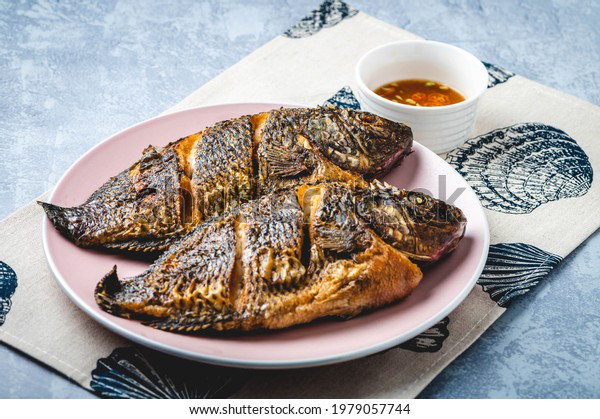

In [547]:
read_image_from_url(url)

In [465]:
selected['energy'].mean()

185.0